# COCS2673 Assignment 2 P1A - Is or is not cancer prediction

In [1]:
#!pip install tensorflow

In [2]:
#import zipfile
#with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
#   zip_ref.extractall('./')

In [3]:
#!pwd

In [4]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

import pandas as pd

tf.__version__

'2.5.0'

# Load Data
Split data into train, validation, and test
Note that images for the same patient may contain a mix of cancerous and non-cancerous data.
Q - Sould we split on patient or just randomly



In [5]:
mainData = pd.read_csv('./data_labels_mainData.csv')
extraData = pd.read_csv('./data_labels_extraData.csv')

In [6]:
#mainData = mainData.sample(2000)
mainData = mainData.append(extraData, ignore_index=True)

# Exploratary Data Analysis (EDA)

In [7]:
print(mainData.dtypes)
#print(mainData.shape)
#print(mainData.info())
print(mainData.describe())


InstanceID        int64
patientID         int64
ImageName        object
cellTypeName     object
cellType        float64
isCancerous       int64
dtype: object
         InstanceID     patientID     cellType   isCancerous
count  20280.000000  20280.000000  9896.000000  20280.000000
mean   11163.660848     55.681065     1.501516      0.348570
std     6481.457867     28.891837     0.954867      0.476529
min        1.000000      1.000000     0.000000      0.000000
25%     5551.750000     29.000000     1.000000      0.000000
50%    11111.500000     63.000000     2.000000      0.000000
75%    16756.250000     81.000000     2.000000      1.000000
max    22444.000000     99.000000     3.000000      1.000000


Update Categorical Data types

In [8]:
mainData['cellType'] = mainData['cellType'].astype('category')
mainData['cellTypeName'] = mainData['cellTypeName'].astype('category')


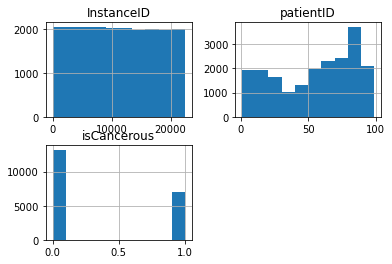

In [9]:
mainData.hist()
plt.show()

In [10]:
mainData.drop(['InstanceID'], axis=1,inplace=True)
mainData.drop(['cellType'], axis=1,inplace=True)
mainData.drop(['cellTypeName'], axis=1,inplace=True)


In [11]:
mainData['isCancerous'] = mainData['isCancerous'].astype('category')

#mainData['cellTypeName'] = mainData['cellTypeName'].astype('category')
#mainData['cellType'] = mainData['cellType'].astype('category')

#? One hot encode cellType?


In [12]:
mainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20280 entries, 0 to 20279
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   patientID    20280 non-null  int64   
 1   ImageName    20280 non-null  object  
 2   isCancerous  20280 non-null  category
dtypes: category(1), int64(1), object(1)
memory usage: 336.9+ KB


In [13]:
mainData.isnull().sum()

patientID      0
ImageName      0
isCancerous    0
dtype: int64

In [14]:
#for i, col in enumerate(mainData.columns):
#    print("==>", col)
#    print(mainData[col].value_counts())
#    print()

In [15]:
neg, pos = np.bincount(mainData.isCancerous)
total = neg + pos
print('Class Data:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Class Data:
    Total: 20280
    Positive: 7069 (34.86% of total)



#### Key observations:
* Data has 20280  observations and 6 columns.
* InstanceID - is Id field, need to remove as not valueable classification attribute
* cellTypeName, cellType - indicator of actual cell type and not used in this case for cancer diagnosis
* isCancerous - indicator of the actual diagnosis (1 = cancerous, 0 = benign)

Split of benign to cancerous is a 35% cancerous, 65% benign

Check all image files exist

In [16]:
import glob

image_list = set()
for filepath in glob.glob('./patch_images/*', recursive=True): #assuming gif
    filename = filepath.split("\\")[-1]
    image_list.add(filename)
    
print(len(image_list))

20280


# Train/Validation/Test Split on Patients

### Add classification class

In [17]:
mainData['isCancerous'] = mainData['isCancerous'].astype('str')

### Split Data into Train/Validate/Test
For test and training data split via person.
- Check if a person has cancer or not, then would the images for that person have cancer?

In [18]:
# Get list of patients and observation counts
TEST_RATIO = 0.10
VAL_RATIO = 0.15


In [19]:
# Split train tests by ratios
# Select random patients until the number of images for 
# each patient sums to the number of records require

np.random.seed(43) # Consistent random list

recCount = mainData.shape[0]
custRec = mainData.patientID.value_counts().to_dict()
    
patientIds = list(custRec.keys())

# Loop through selecting a patient at random summing the number of images they have
# until the count of images crosses is more than required number

testCust = []
testRecs = 0
while (testRecs < (recCount * TEST_RATIO)):
    pId = np.random.choice(patientIds)
    ic = custRec.get(pId)
    patientIds.remove(pId)
    testCust.append(pId)
    testRecs += ic
    
#print(testCust, testRecs)

valCust = []
valRecs = 0
while (valRecs < (recCount * VAL_RATIO)):
    pId = np.random.choice(patientIds)
    ic = custRec.get(pId)
    patientIds.remove(pId)
    valCust.append(pId)
    valRecs += ic

#print(valCust, valRecs)

In [20]:
testData = mainData[mainData.patientID.isin(testCust)]
valData = mainData[mainData.patientID.isin(valCust)]
trainData = mainData[~(mainData.patientID.isin(valCust + testCust))]

In [21]:
#print(trainData.shape[0] + valData.shape[0] + testData.shape[0])
#print(mainData.shape[0])
print("Train data : {}, Val Data: {}, Test Data: {}".format(trainData.shape[0], valData.shape[0], testData.shape[0]))

Train data : 15054, Val Data: 3055, Test Data: 2171


In [22]:
trainData.head()

,patientID,ImageName,isCancerous
19,2,19035.png,0
20,2,19036.png,0
21,2,19037.png,0
22,2,19038.png,0
23,2,19039.png,0


([0, 1], [Text(0, 0, ''), Text(0, 0, '')])

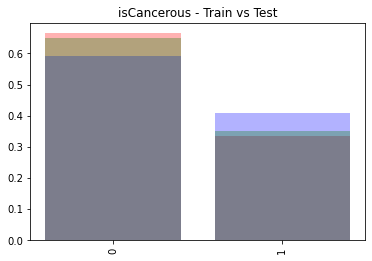

In [23]:
plt.bar(
    trainData.isCancerous.value_counts().index.astype(str), 
    trainData.isCancerous.value_counts().values/np.sum(trainData.isCancerous.value_counts().values), 
    alpha=0.3, 
    color='r')
plt.bar(
    valData.isCancerous.value_counts().index.astype(str), 
    valData.isCancerous.value_counts().values/np.sum(valData.isCancerous.value_counts().values), 
    alpha=0.3, 
    color='b')
plt.bar(
    testData.isCancerous.value_counts().index.astype(str), 
    testData.isCancerous.value_counts().values/np.sum(testData.isCancerous.value_counts().values), 
    alpha=0.3, 
    color='g')
plt.title('isCancerous - Train vs Test')
plt.xticks(rotation='vertical')

# Images
27x27 RGB 

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainData,
        directory='./patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=valData,
        directory='patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

test_generator = val_datagen.flow_from_dataframe(
        dataframe=testData,
        directory='patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

Found 15054 validated image filenames belonging to 2 classes.
Found 3055 validated image filenames belonging to 2 classes.
Found 2171 validated image filenames belonging to 2 classes.


### Utility Functions

In [25]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [26]:
def PlotModelFitHistory(mh):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(mh.history['loss'], 'r--')
    plt.plot(mh.history['val_loss'], 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(mh.history['binary_accuracy'], 'r--')
    plt.plot(mh.history['val_binary_accuracy'], 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()


In [27]:
def PlotConfusionMatrix(test, pred):
    cm = confusion_matrix(test, test)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm, annot=labels, fmt='', cmap='Blues')

# Models

### Measure 
As this is a screening task, the impact of a false negative is high (ie someone who has cancer is missed)
In this case use Recall for measure.
We can also use F1 to get a more balanced measure of Precision and Recall

In [28]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 1

## 1. Baseline an simple MLP Model
Observations
* Use a initial NN to get a baseline
* Binary classification problem
* Input has 2187 dims
* 1 hidden layer with 256 internal nodes
* 1 output binary
* Loss - Binary Cross Entropy
* Metric - binary_accuracy 
* use sigmoid activation as this is a logistics issue



In [29]:
import tensorflow as tf

model_base = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='sigmoid')
])

In [30]:
model_base.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2187)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               560128    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 560,385
Trainable params: 560,385
Non-trainable params: 0
_________________________________________________________________


In [31]:
model_base.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['binary_accuracy'])

In [32]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

history_base = model_base.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)

10:57:27
11:41:00
Took =  0:43:33.036628


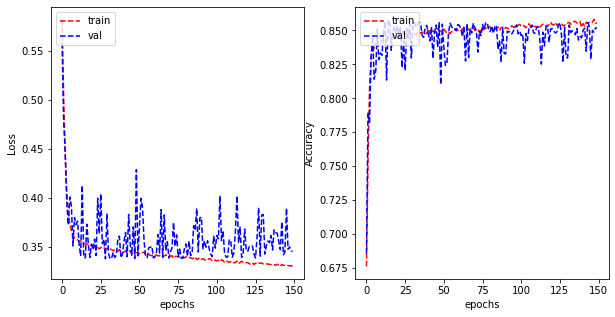

In [33]:
PlotModelFitHistory(history_base)


In [41]:
test_y = testData['isCancerous'].astype('int')

pred_y_base = model_base.predict(test_generator, batch_size=64, verbose=1)
pred_y_base = np.argmax(pred_y_base, axis=1)


68/68 [==============================] - 2s 33ms/step


In [42]:
print(classification_report(test_y, pred_y_base, zero_division=0))

              precision    recall  f1-score   support

           0       0.65      1.00      0.79      1409
           1       0.00      0.00      0.00       762

    accuracy                           0.65      2171
   macro avg       0.32      0.50      0.39      2171
weighted avg       0.42      0.65      0.51      2171



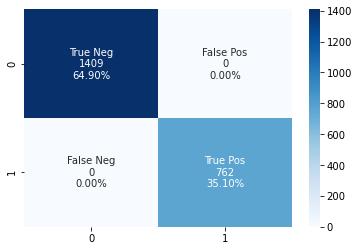

In [43]:
PlotConfusionMatrix(test_y, pred_y_base)

### Observation
* Train vs Validation approaches at 150 epocs
* There looks to be some overfitting
* Recall is good (?) maybe too good 
* Precision low low at 0.40
* F1 score low at 0.64

### Try some regularisation

In [36]:
# Use default lambda - note for assignment only. In real this might be in loop to determine best value.
reg_lambda = 0.01

model_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [37]:
model_reg.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['binary_accuracy'])

In [38]:
model_reg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               560128    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 560,385
Trainable params: 560,385
Non-trainable params: 0
_________________________________________________________________


In [39]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

history_reg = model_reg.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)


11:41:04


KeyboardInterrupt: 

In [ ]:
PlotModelFitHistory(history_reg)


In [ ]:
pred_y_reg = model_reg.predict(test_generator, batch_size=64, verbose=1)
pred_y_reg = np.argmax(pred_y_reg, axis=1)

In [ ]:
print(classification_report(test_y, pred_y_reg, zero_division=0))

In [ ]:
PlotConfusionMatrix(test_y, pred_y_reg)

### Try some dropout

In [ ]:
reg_lambda = 0.01

model_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid')
])

In [ ]:
model_drop.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['binary_accuracy'])

In [ ]:
model_drop.summary()

In [ ]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

history_drop = model_drop.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)

In [ ]:
PlotModelFitHistory(history_drop)

Also improves but test data looks to be better than training

In [ ]:
pred_y_drop = model_drop.predict(test_generator, batch_size=64, verbose=1)
pred_y_drop = np.argmax(pred_y_drop, axis=1)

In [ ]:
print(classification_report(test_y, pred_y_drop))

In [ ]:
PlotConfusionMatrix(test_y, pred_y_drop)

## 2. Baseline Plus VGG

In [ ]:
model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(
        OUTPUT_CLASSES, 
        kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
        activation='sigmoid' )
])

In [ ]:
model_VGG_1.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['binary_accuracy'])

In [ ]:
model_VGG_1.summary()

In [ ]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

history_VGG_1 = model_VGG_1.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)

In [ ]:
PlotModelFitHistory(history_VGG_1)

In [ ]:
pred_y_vgg1 = model_VGG_1.predict(test_generator, batch_size=64, verbose=1)
pred_y_vgg1 = np.argmax(pred_y_vgg1, axis=1)

In [ ]:
print(classification_report(test_y, pred_y_vgg1, zero_division=0))

In [ ]:
PlotConfusionMatrix(test_y, pred_y_vgg1)

## VGG 2
Observations

Issue is over fitting 
* We have 20k images so that should be ok for training
* image size is small so down scaling is not too beneficial
* after 40 epics so could stop early 
* over fitting so reduce the number of convolutions
* Given number of images, data augmentation probably not required


In [ ]:
model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(
        OUTPUT_CLASSES, 
        kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
        activation='sigmoid' )
])

In [ ]:
model_VGG_2.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['binary_accuracy'])

In [ ]:
model_VGG_2.summary()

In [ ]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

history_VGG_2 = model_VGG_2.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)

In [ ]:
PlotModelFitHistory(history_VGG_2)

In [ ]:
pred_y_vgg2 = model_VGG_2.predict(test_generator, batch_size=64, verbose=1)
pred_y_vgg2 = np.argmax(pred_y_vgg2, axis=1)

In [ ]:
print(classification_report(test_y, pred_y_vgg2, zero_division=0))

In [ ]:
PlotConfusionMatrix(test_y, pred_y_vgg2)